In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
!mkdir data

In [4]:
!unzip '/content/drive/MyDrive/temp_data/cv_competition_data.zip' -d .


Streaming output truncated to the last 5000 lines.
  inflating: ./data/trainset/A_XKWxQoI6i9YAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XkxJRrLMuDgAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_xKYDRbLvo9wAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_Xkz2S64lclQAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XkzxQbyaG6sAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_xK_2SJPY5XYAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_Xk_xQ55RL9YAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XL0rRK16D5kAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_xl1nT7DZ67EAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XL1tQK1HhAsAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_xL4kR73qJUJhUHlLg5dbRwAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XL5mTbshRgEAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_XLbDSIpKwEEAAAAAAAAAAAAAAQAAAQ.jpg  
  inflating: ./data/trainset/A_xlBmQI1pG4MAAAAAAAAAAAAAAQAAAQ.jpg

In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time
import os
import shutil
from PIL import Image
from tqdm import tqdm

In [15]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        """
        Args:
            root_dir (string): 项目根目录。
            mode (string): 模式，包含train, validate, test
            transform (callable, optional): 可选的转换操作。
        """
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])

        self.root_dir = root_dir
        self.transform = transform

        self.annotation_path = os.path.join(root_dir, f'data/annotations/{"val" if mode == "test" else "train"}.txt')
        self.img_path_dir = os.path.join(root_dir, f'data/{"val" if mode == "test" else "train"}set')

        self.samples = self.get_annotations(mode, self.annotation_path)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, label = self.samples[idx]
        img_path = os.path.join(self.img_path_dir, img_name).replace("*", "_")

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return (img_name, image), label

    def get_annotations(self, mode, annotation_path):
        image_labels = []
        with open(annotation_path, 'r') as file:
            for line in file:
                img_name, label = line.strip().split()
                image_labels.append((img_name, int(label)))

        count = len(image_labels)
        # count = 100
        if mode == "validate":
            image_labels = image_labels[:count//10]
        elif mode == "train":
            image_labels = image_labels[count//10:count]

        return image_labels

def get_dataset(root_dir, mode):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = CustomDataset(root_dir, mode, transform)
    return dataset


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1, 2, 0)))
    plt.show()

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of image names: ('A*2VCWTI4umecAAAAAAAAAAAAAAQAAAQ.jpg', 'A*lNhiRLimyyEAAAAAAAAAAAAAAQAAAQ.jpg', 'A*BIU5TqgNNBIAAAAAAAAAAAAAAQAAAQ.jpg', 'A*OjegRakpTaMAAAAAAAAAAAAAAQAAAQ.jpg', 'A*F5HaQpWtGKUAAAAAAAAAAAAAAQAAAQ.jpg', 'A*r52aSqzf6RcAAAAAAAAAAAAAAQAAAQ.jpg', 'A*Y4HwQo3KYjjaXZBKkdPkRwAAAQAAAQ.jpg', 'A*JHBISI5XJ-EqBG1OmXInMQAAAQAAAQ.jpg', 'A*tQwoTIAJnmwAAAAAAAAAAAAAAQAAAQ.jpg', 'A*b7NzRrz860kAAAAAAAAAAAAAAQAAAQ.jpg', 'A*lqMyRYNk1WUAAAAAAAAAAAAAAQAAAQ.jpg', 'A*GXzvRoXNJzkAAAAAAAAAAAAAAQAAAQ.jpg', 'A*ObABSK1TVdYAAAAAAAAAAAAAAQAAAQ.jpg', 'A*NNYXQYvSUMEAAAAAAAAAAAAAAQAAAQ.jpg', 'A*KEYKRZWIOYcAAAAAAAAAAAAAAQAAAQ.jpg', 'A*fBiATbOkEk8AAAAAAAAAAAAAAQAAAQ.jpg', 'A*esSET43sVO4AAAAAAAAAAAAAAQAAAQ.jpg', 'A*NLM2RpHaqfoAAAAAAAAAAAAAAQAAAQ.jpg', 'A*5HpRRqKcngPEFOpDmI15uAAAAQAAAQ.jpg', 'A*HqGQSIPF5SkAAAAAAAAAAAAAAQAAAQ.jpg', 'A*w7kzQbOxc0MAAAAAAAAAAAAAAQAAAQ.jpg', 'A*syy5R6Uy2D8JQyxGgj_wCgAAAQAAAQ.jpg', 'A*LtygRpyGj98AAAAAAAAAAAAAAQAAAQ.jpg', 'A*J

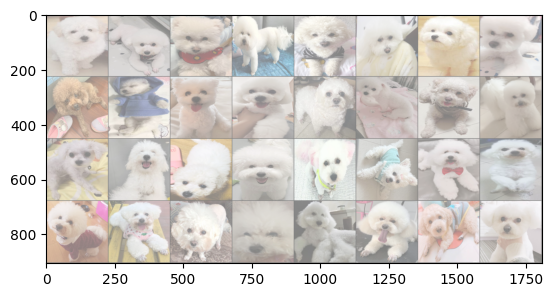

Labels:
 A*eqeWQZOxF_wAAAAAAAAAAAAAAQAAAQ.jpg:  36;
A*40azQogwODwAAAAAAAAAAAAAAQAAAQ.jpg:  66;
A*gwlLSoWsZ_UAAAAAAAAAAAAAAQAAAQ.jpg:  18;
A*hrjyQ5kAXNMAAAAAAAAAAAAAAQAAAQ.jpg:  36;
A*QMtzRotNsSwAAAAAAAAAAAAAAQAAAQ.jpg:  82;
A*AJuAQ5O1Ww0AAAAAAAAAAAAACjV1AQ&bz.jpg:  28;
A*KADaR5vKa6mTrc9EppvirwAAAQAAAQ.jpg:  12;
A*q0HQQLTQFRkAAAAAAAAAAAAAAQAAAQ.jpg:  26;
A*k0l6ToGGDgUAAAAAAAAAAAAAAQAAAQ.jpg:  78;
A*f5G8RLAaQpsAAAAAAAAAAAAAAQAAAQ.jpg:  26;
A*AGfrR4mR8pQAAAAAAAAAAAAAAQAAAQ.jpg:   5;
A*0lZtSYQCzN0AAAAAAAAAAAAAAQAAAQ.jpg:  42;
A*jIPlSakGQlYAAAAAAAAAAAAAAQAAAQ.jpg:  92;
A*kfznRIbvg3AAAAAAAAAAAAAAAQAAAQ.jpg:  52;
A*JYgHTpUmQIAAAAAAAAAAAAAAAQAAAQ.jpg:  29;
A*2a-YTbx9BhAAAAAAAAAAAAAAAQAAAQ.jpg:  53;
A*YroVQ6nKE6IAAAAAAAAAAAAAAQAAAQ.jpg:  33;
A*Q9FMQY9Tw9UAAAAAAAAAAAAAAQAAAQ.jpg:  20;
A*n8hOTaN3KvMAAAAAAAAAAAAAAQAAAQ.jpg:  25;
A*O4YxS7h-gdMAAAAAAAAAAAAAAQAAAQ.jpg:  18;
A*yVFkRqanVgwAAAAAAAAAAAAAAQAAAQ.jpg:  16;
A*16dqTq9Jxxn6S2VPnQFX5wAAAQAAAQ.jpg:   4;
A*k8MjRJ302MEAAAAAAAAAAAAAAQAAAQ.jpg:  34;

In [16]:
# 定义转换
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 项目根目录
root_dir = '.'

# 创建数据集和数据加载器
dataset = CustomDataset(root_dir=root_dir, mode="train", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 遍历数据并打印图像和标签的形状
for (names, images), labels in dataloader:
    print(f'Batch of images shape: {images.shape}')  # 打印图像的形状
    print(f'Batch of image names: {names}')  # 打印标签
    print(f'Batch of labels: {labels}')  # 打印标签
    break  # 只打印一个批次的数据以进行测试

# get some random training images
dataiter = iter(dataloader)
(names, images), labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:\n', '\n'.join('%20s: %3d;' % (names[j], labels[j]) for j in range(32)))

In [23]:
class MyResNetModel(nn.Module):
    def __init__(self, frozen_mode):
        super(MyResNetModel, self).__init__()

        resnet = models.resnet50(pretrained=True)

        layers_to_freeze = [resnet.conv1, resnet.bn1, resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4]

        frozen_layers = frozen_mode  # frozen_mode 表示冻结到哪个层
        for i in range(frozen_layers):
            for param in layers_to_freeze[i].parameters():
                param.requires_grad = False

        # 创建不包含全连接层的 ResNet 模型
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # 去掉最后的全连接层
        # 添加自定义的全连接层
        self.fc = nn.Linear(resnet.fc.in_features, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [24]:
def train(device, train_loader, validate_loader, model, optimizer, criterion, max_epochs, save_path):
    """
    Train the model for regression with early stopping based on validation loss.

    Args:
        device (torch.device): The device to use for training (e.g., "cuda" or "cpu").
        train_loader (DataLoader): DataLoader for the training dataset.
        validate_loader (DataLoader): DataLoader for the validation dataset.
        model (nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        criterion (nn.Module): Loss function for regression (e.g., MSELoss).
        max_epochs (int): Maximum number of epochs to train.
        save_path (str): Directory to save the best model.
    """
    best_loss = float('inf')
    patience = 3  # Stop if no improvement for 3 consecutive epochs
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        # Training loop
        for (names, images), labels in tqdm(train_loader, desc="Epoch_" + str(epoch) + " Train Processing:"):
            images, labels = images.to(device), labels.to(device).float()

            # Forward pass
            outputs = model(images).squeeze(1)  # Ensure outputs are 1D
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        validate_loss = 0.0

        with torch.no_grad():
            for (names, images), labels in tqdm(validate_loader, desc="validation Processing:"):
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                validate_loss += loss.item()

        avg_validate_loss = validate_loss / len(validate_loader)
        print(f"Validation Loss: {avg_validate_loss:.4f}")

        is_best = False
        # Check for improvement
        if avg_validate_loss < best_loss:
            print("Validation loss improved, saving model...")
            is_best = True
            best_loss = avg_validate_loss
            patience_counter = 0
        else:
            patience_counter += 1
        save_checkpoint(model.state_dict(), save_path, is_best, epoch)

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered. Best validation loss:", best_loss)
            break

    print("Training complete. Best validation loss:", best_loss)


def save_checkpoint(state, save_root, is_best, epoch):
    if not os.path.exists(save_root):
        os.makedirs(save_root)
    save_path = os.path.join(save_root, 'epoch_{}.pth.tar'.format(str(epoch)))
    torch.save(state, save_path)

    best_path = os.path.join(save_root, 'best_model.pth.tar'.format(str(epoch)))
    torch.save(state, best_path)

In [ ]:
!rm -r save_0 save_1 save_2 save_3 save_4 save_5 save_6

In [ ]:
!mkdir save_0 save_1 save_2 save_3 save_4 save_5 save_6

In [26]:
def test(device, test_loader, model, criterion, frozen_mode):
    """
    Evaluate the model on the test set.

    Args:
        device (torch.device): The device to use for testing (e.g., "cuda" or "cpu").
        test_loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): The trained model.
        criterion (nn.Module): Loss function for regression (e.g., MSELoss).

    Returns:
        float: The average test loss.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_samples = 0
    total_correct = 0  # For accuracy or other metrics if needed

    with torch.no_grad():  # No need to track gradients during testing
        with open(f'output_{frozen_mode}.txt', 'w', encoding='utf-8') as file:
            for (names, images), labels in tqdm(test_loader, desc="Eval Processing:"):
                images, labels = images.to(device), labels.to(device).float()

                # Forward pass
                outputs = model(images).squeeze(1)  # Ensure outputs are 1D

                for i, name in enumerate(names):
                    file.write(f"{name}\t{round(outputs[i].item())}\n")

                loss = criterion(outputs, labels)

                test_loss += loss.item()

                # If you want to compute additional metrics, like MSE or MAE, you can do so here
                # For example, to compute MAE:
                total_samples += len(labels)
                total_correct += torch.abs(outputs - labels).sum().item()  # Absolute error

    avg_test_loss = test_loss / len(test_loader)
    avg_mae = total_correct / total_samples  # Mean Absolute Error

    print(f"{frozen_mode}: ")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test MAE: {avg_mae:.4f}")

    return avg_test_loss, avg_mae

In [ ]:
print("Start...")
root_dir = '.'
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = torch.nn.MSELoss()

train_dataset = get_dataset(root_dir, "train")
validate_dataset = get_dataset(root_dir, "validate")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=False)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=False)

max_frozen_mode = 6
for frozen_mode in range(max_frozen_mode+1):
    model = MyResNetModel(frozen_mode).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(
        device,
        train_loader,
        validate_loader,
        model,
        optimizer,
        criterion,
        max_epochs=50,
        save_path=os.path.join(root_dir, f"save_{frozen_mode}")
    )
    
    print(f"training {frozen_mode} over...")

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = '.'
batch_size = 32

test_dataset = get_dataset(root_dir, "test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=False)

for i in range(max_frozen_mode+1):
    model = MyResNetModel(frozen_mode)

    model_path = os.path.join(root_dir, f"save_{i}/best_model.pth.tar")  # 模型保存路径
    model.load_state_dict(torch.load(model_path))  # 加载权重到模型
    model.to(device)

    criterion = torch.nn.MSELoss()

    avg_test_loss, avg_mae = test(device, test_loader, model, criterion, frozen_mode)

<ipython-input-27-28a8571cecc4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # 加载权重到模型
Eval Processing:: 100%|██████████| 

Test Loss: 1309.1686
Test MAE: 26.7188
1309.1685667646693 26.718840148925782
